# Project Report for Group 4

## Ship Route Optimization

What?
What is the scope of work

Mathematical model

In [1]:
### Add packages here
# using Pkg
# # Pkg.add("StatsBase")
# Pkg.add("Juniper")

In [2]:
using PyPlot, MeshGrid, StatsBase, LinearAlgebra

In [3]:
using JuMP, GLPK, COSMO, Gurobi, Juniper, Ipopt

### Helper Functions

In [4]:
function nodeToNum(node, n)
   return node[1]*n+node[2];
end

nodeToNum (generic function with 1 method)

In [5]:
function nodeToCoord(node, spacing)
   return spacing*node
end

nodeToCoord (generic function with 1 method)

In [6]:
function numToCoord(num, n, spacing)
    node_y = div.(num, n);
    node_x = num.%n;
    node = hcat(node_x, node_y);
    return spacing*node;
end

numToCoord (generic function with 1 method)

In [7]:
function numToNode(num, n)
    node_y = div.(num, n);
    node_x = num.%n;
    node = hcat(node_x, node_y);
    return node;
end

numToNode (generic function with 1 method)

In [8]:
function initializeParam(n, spacing, m, k, fill_ratio = 0.25)
    grid_size = n*n;
       
    # Check that values are whole numbers
    if m <= 1
        error("Increase m!")
    end
    
    # Check that values are whole numbers
    if !isinteger(n) || !isinteger(m) || !isinteger(k)
        error("Only integer values are allowed for n, m and k!")
    end
        
    # Check that number of ports and no-go zones does not exceed a certain percentage of grid size
    if (k + m) >= fill_ratio*grid_size
        error("Number of ports and no-go zones cannot exceed $(fill_ratio*100)% of grid size. Reinitialize numnber of ports!")
    end
    
    grid_data = [n, spacing, m, k];
end

initializeParam (generic function with 2 methods)

In [9]:
function randomizePorts(grid_data)
### randomize location of all ports and no-go zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]);

    # assign nodes to ports and no-go zones
    node = rand(0:n-1, m+k, 2);
    coord = spacing*node;

    port_coord = coord[1:m, :]
    no_go_coord = coord[m+1:end, :];

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_coord = port_coord[rand_idx, :]

    return port_coord, no_go_coord, port_of_origin_coord
    
end

randomizePorts (generic function with 1 method)

In [10]:
function randomizePortsNoRepeat(grid_data)
### randomize location of all ports and no-go zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]);

    total_nodes = n^2;
    pool = 0:(total_nodes-1);

    # assign nodes to ports and no-go zones
    nums = sample(pool, m+k, replace=false);
    port_num = nums[1:m, :];
    no_go_num = nums[m+1:end, :];
    
    # node = hcat(node_x, node_y)
    # coord = spacing*node;

    # port_node = numToNode(port_num, n);
    # port_coord = spacing*port_node;
    # no_go_node = numToNode(no_go_num, n);
    # no_go_coord = spacing*no_go_node;

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_num = port_num[rand_idx];
    # port_of_origin_node = numToNode(port_of_origin_num, n);
    # port_of_origin_coord = spacing*port_of_origin_node;

    return port_num, port_of_origin_num, no_go_num
    
end

randomizePortsNoRepeat (generic function with 1 method)

In [11]:
function visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, soln)
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    origin = [0, 0];

    port_coord = numToCoord(port_num, n, spacing);
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing);
    no_go_coord = numToCoord(no_go_num, n, spacing);

    grid_size = n^2;

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)];
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)];

    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y);
    # size(grid_points_mesh);

    grid_points = hcat(grid_points_x, grid_points_y);
    # grid_points = [grid_points_x, grid_points_y];
    size(grid_points);

    # plot
    grid_color_RGB = [248, 131, 121]./255;
    alpha_plot = 0.5;
    fig_size = max((10,10),(n, n));
    f = figure(figsize=(5, 5));
    scatter(grid_points_x, grid_points_y, alpha = alpha_plot, color = grid_color_RGB, s = 20);
    ax = gca();
    ax.axis("equal");
    ax.axis("off"); # hide axes spines/values

    # plot port data
    port_color_RGB = [25, 100, 50]./255;
    alpha_port = 1;
    scatter(port_coord[:, 1], port_coord[:, 2], alpha = alpha_port, color = port_color_RGB, marker = "o", s = 100);

    # plot no_go data
    no_go_color_RGB = [0, 0, 0]./255;
    alpha_no_go = 1;
    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha = alpha_no_go, color = no_go_color_RGB, marker = "x", s = 150);

    # plot port of origin
    origin_port_color_RGB = [255, 87, 51]./255;
    alpha_origin_port = 1;
    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha = alpha_origin_port, color = origin_port_color_RGB, marker = "*", s = 200);

    if soln != 0
        # plot edges
        for i=0:grid_size-1
            for j=0:grid_size-1
                if soln[i+1, j+1] == 1
                    # println(soln[i+1, j+1])
                    line_start = numToCoord(i, n, spacing);
                    line_end = numToCoord(j, n, spacing);

                    # println(line_start);
                    # println(line_end);
    
                    # plot([line_start[1], line_end[1]], [line_start[2], line_end[2]], "r-")
                    arrow(line_start[1], line_start[2],  line_end[1]-line_start[1], line_end[2]- line_start[2], head_width=0.2, head_length=0.2, fc="lightyellow", ec="orange")
                end
            end
        end
    end

    # plot([0, 1], [1, 2], "r-")
    return f 
end

visualizeGrid (generic function with 1 method)

## Minimize total distance travelled

In [12]:
function optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;

    # Total cost
    cost = 0; 
    
    # idx=0;
    
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            c[i+1, j+1] = norm(numToCoord(i, n, spacing)- numToCoord(j, n, spacing));
            cost += c[i+1, j+1]*x[i, j];
              
            # all edges other than the eight closest ones are zero 
            if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1); # or sum in == 0
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go == 0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMinCost (generic function with 1 method)

## Allow ship to pass through no-go zones but assign penalty

In [13]:
function optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    norm_dist = zeros(grid_size, grid_size);
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    
    cost = 0; 
    
    # idx=0;
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            norm_dist[i+1, j+1] = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing));
            c[i+1, j+1] = norm_dist[i+1, j+1];
            
            # If flow coming in or going out of a no-go zone, increase cost by 1.5
            if in(i, no_go_num) || in(j, no_go_num)
                c[i+1, j+1] *= penalty_factor;              
            end

            cost += c[i+1, j+1]*x[i, j];
            
            # all edges other than the eight closest ones are zero 
            if norm_dist[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
        
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO == 1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1);
    
    ## for other ports
    # for if-then constraints
    e = 1; # epsilon
    l = -1; # lower bound
    u = 2; # upper bound
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_no_go - sum_in_no_go ==0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    @show model

    set_optimizer(model, solver.Optimizer);
    # set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
            
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelAllowNoGo (generic function with 1 method)

### Initialize parameters

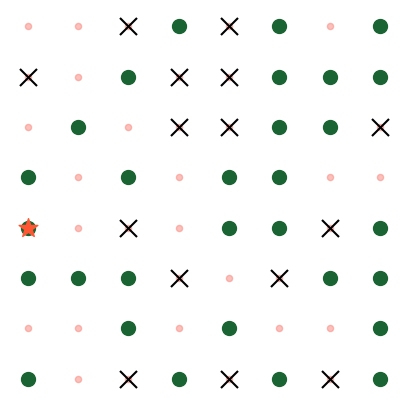

In [14]:
### Grid setup
# grid size (square)
n = 8;
spacing = 1; # always keep 1?

### port information
# number of ports on grid
m = 30;

### no-go zones
k = 15;

grid_data = initializeParam(n, spacing, m, k, 0.95);
port_num, port_of_origin_num, no_go_num = randomizePortsNoRepeat(grid_data)
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, 0);

### Solve Model

Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
OPTIMAL
Objective value: 40.55634918610404


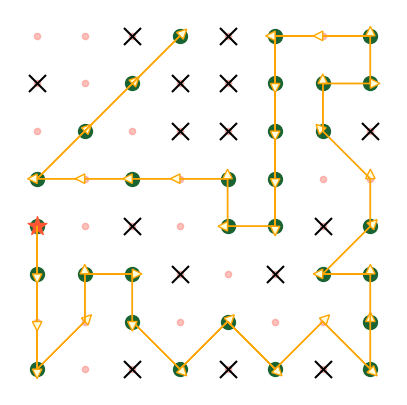

In [15]:
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 4190
├ num_constraints: 13913
│ ├ AffExpr in MOI.EqualTo{Float64}: 3742
│ ├ AffExpr in MOI.LessThan{Float64}: 5981
│ ├ VariableRef in MOI.GreaterThan{Float64}: 64
│ └ VariableRef in MOI.ZeroOne: 4126
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9723 rows, 4190 columns and 29504 nonzeros
Model fingerprint: 0xb2131ac3
Variable types: 64 continuous, 4126 integer (4126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 1e+01]
 

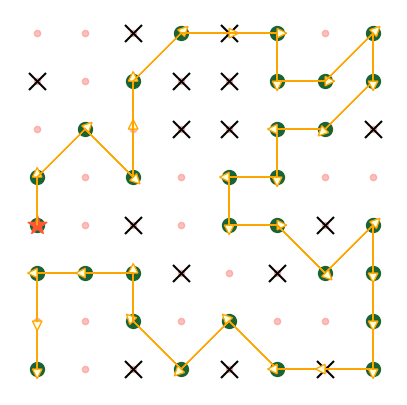

In [16]:
solver = Gurobi;
penalty_factor = 1.0;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 4190
├ num_constraints: 13913
│ ├ AffExpr in MOI.EqualTo{Float64}: 3742
│ ├ AffExpr in MOI.LessThan{Float64}: 5981
│ ├ VariableRef in MOI.GreaterThan{Float64}: 64
│ └ VariableRef in MOI.ZeroOne: 4126
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9723 rows, 4190 columns and 29504 nonzeros
Model fingerprint: 0xb0b48a21
Variable types: 64 continuous, 4126 integer (4126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [5e-01, 1e+01]
 

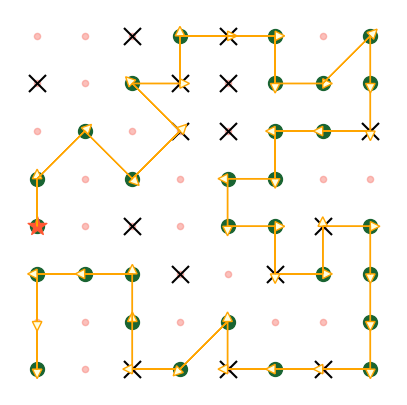

In [17]:
solver = Gurobi;
penalty_factor = 0.5;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 4190
├ num_constraints: 13913
│ ├ AffExpr in MOI.EqualTo{Float64}: 3742
│ ├ AffExpr in MOI.LessThan{Float64}: 5981
│ ├ VariableRef in MOI.GreaterThan{Float64}: 64
│ └ VariableRef in MOI.ZeroOne: 4126
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9723 rows, 4190 columns and 29504 nonzeros
Model fingerprint: 0xb7f33071
Variable types: 64 continuous, 4126 integer (4126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 9e+01]
 

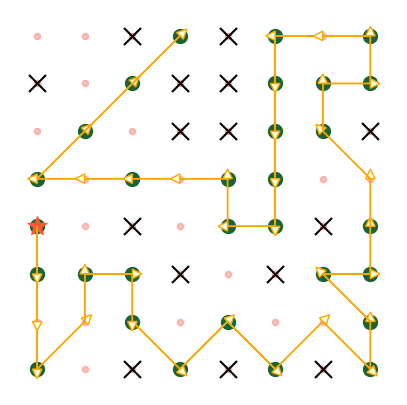

In [18]:
solver = Gurobi;
penalty_factor = 10;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

In [19]:
# For if-then conditions
# utilize previous conditions to ensure good constraints

# why can't lines be eliminated by saying sum of ports with one outgoing 1?